## Задача
- Сравнить пиковые коэффициенты отражения зеркала Cr/Sc в диапазоне энергий "окна прозрачности воды" со значениями для структур, содержащих азот: CrNx/Sc, Cr/ScNx, CrNx/ScNx

## Методы расчета

Для оценки значений пиковых коэффициентов отражения и эффективного числа периодов для многослойной структуры использовались формулы из работы https://doi.org/10.1007/BF02581074 I.V. Kozhevnikov, A.V. Vinogradov, "Multilayer X-ray mirrors", Journal of Russian Laser Research, vol. 16, no. 4, 1995. 
Для каждой пары материалов будем выбирать такое соотношение толщин, которое является оптимальным для рассматриваемой энергии. Оптимальное соотношение оценивалось также на основе формулы из работы.

In [1]:
# загрузим необходимые библиотеки для работы
import os
import sys
from dotenv import load_dotenv

sys.path.append('../packages')

from bi_mirrors import BiMirror
from compounds import Compound, HC_CONST
from compounds import Element

from typing import List

import plotly.express as px
import pandas as pd

In [2]:
# подгружаем ключи из .env файла
load_dotenv()

# подключаемся к API Materials Project
Compound.set_mapi_key(os.getenv('MAPI_KEY'))

In [3]:
line_params = {
    'width': 800,
    'height': 600,
    'template': 'seaborn',
}

show_params = {
    'renderer': 'png',
    'scale': 2,
}

In [4]:
# рассматриваем диапазон C1s - Sc2p, Sc2p - O1s нет смысла включать, в нем слои скандия сильно поглощают, как и нитриды
en_window = [285, 400]

In [5]:
# будем сохранять загруженные из БД данные для соединений
compounds = {}

# функция для расчета оптимальной гаммы, эффективного числа периодов и пикового коэффициента отражения
# для набора пар материалов
def calc_param(param, mirror_names: list[str], gammas: list):
    mirrors = pd.DataFrame()
        
    for k, mirror_name in enumerate(mirror_names):
        materials = mirror_name.split('/')

        for i in range(len(materials)):
            if materials[i] not in compounds:
                materials[i] = Compound(materials[i])
                compounds[materials[i].chem_formula] = materials[i]
            else:
                materials[i] = compounds[materials[i]]

        match param:
            case 'r_max':
                mirror = BiMirror(*materials).calc_max_reflection(gamma=gammas[k])
            case 'n_eff':
                mirror = BiMirror(*materials).calc_efficient_number_of_periods(gamma=gammas[k])
            case 'opt_gamma':
                mirror = BiMirror(*materials).calc_optimal_gamma()
                
        mirror.name = mirror_name
        mirrors = pd.concat([mirrors, mirror], axis=1)
    
    return mirrors.sort_index().interpolate('index')

## Нитридизация хрома

В качестве нитридов хрома будем рассматривать три материала: Cr2N, CrN, CrN2. Значения плотностей для первых двух материалов возьмем из CRC Handbook of Chemistry and Physics, 95th edition, а для третьего из Materials Project.

In [6]:
# рассматриваемые пары материалов
mirror_names_crn = ['Cr/Sc', 'Cr2N/Sc', 'CrN/Sc', 'CrN2/Sc']

# рассчитываем значения оптимальной гаммы для каждой пары материалов
gammas_crn = calc_param('opt_gamma', mirror_names_crn, []).loc[397.26]

# расчет пиковых коэффициентов отражения
r_max_crn = calc_param('r_max', mirror_names_crn, gammas_crn)
r_max_crn.index.name = 'Energy'

# расчет эффективного числа периодов
n_eff_crn = calc_param('n_eff', mirror_names_crn, gammas_crn)
n_eff_crn.index.name = 'Energy'

ValueError: no such compound in the database


Retrieving SummaryDoc documents:   0%|          | 0/74 [00:00<?, ?it/s]

In [7]:
print('Используемые значения плотностей:')
for comp in ['Sc', 'Cr', 'Cr2N', 'CrN', 'CrN2']:
    print(f'{compounds[comp].chem_formula:>8}: {compounds[comp].density:.2f} g/cm^3')
    
print('\nОптимальные значения gamma:')
for i in range(len(mirror_names_crn)):
    print(f'{mirror_names_crn[i]:>8}: {gammas_crn[i]:.2f}')

Используемые значения плотностей:
      Sc: 2.99 g/cm^3
      Cr: 7.15 g/cm^3
    Cr2N: 6.80 g/cm^3
     CrN: 5.90 g/cm^3
    CrN2: 5.09 g/cm^3

Оптимальные значения gamma:
   Cr/Sc: 0.41
 Cr2N/Sc: 0.43
  CrN/Sc: 0.45
 CrN2/Sc: 0.48


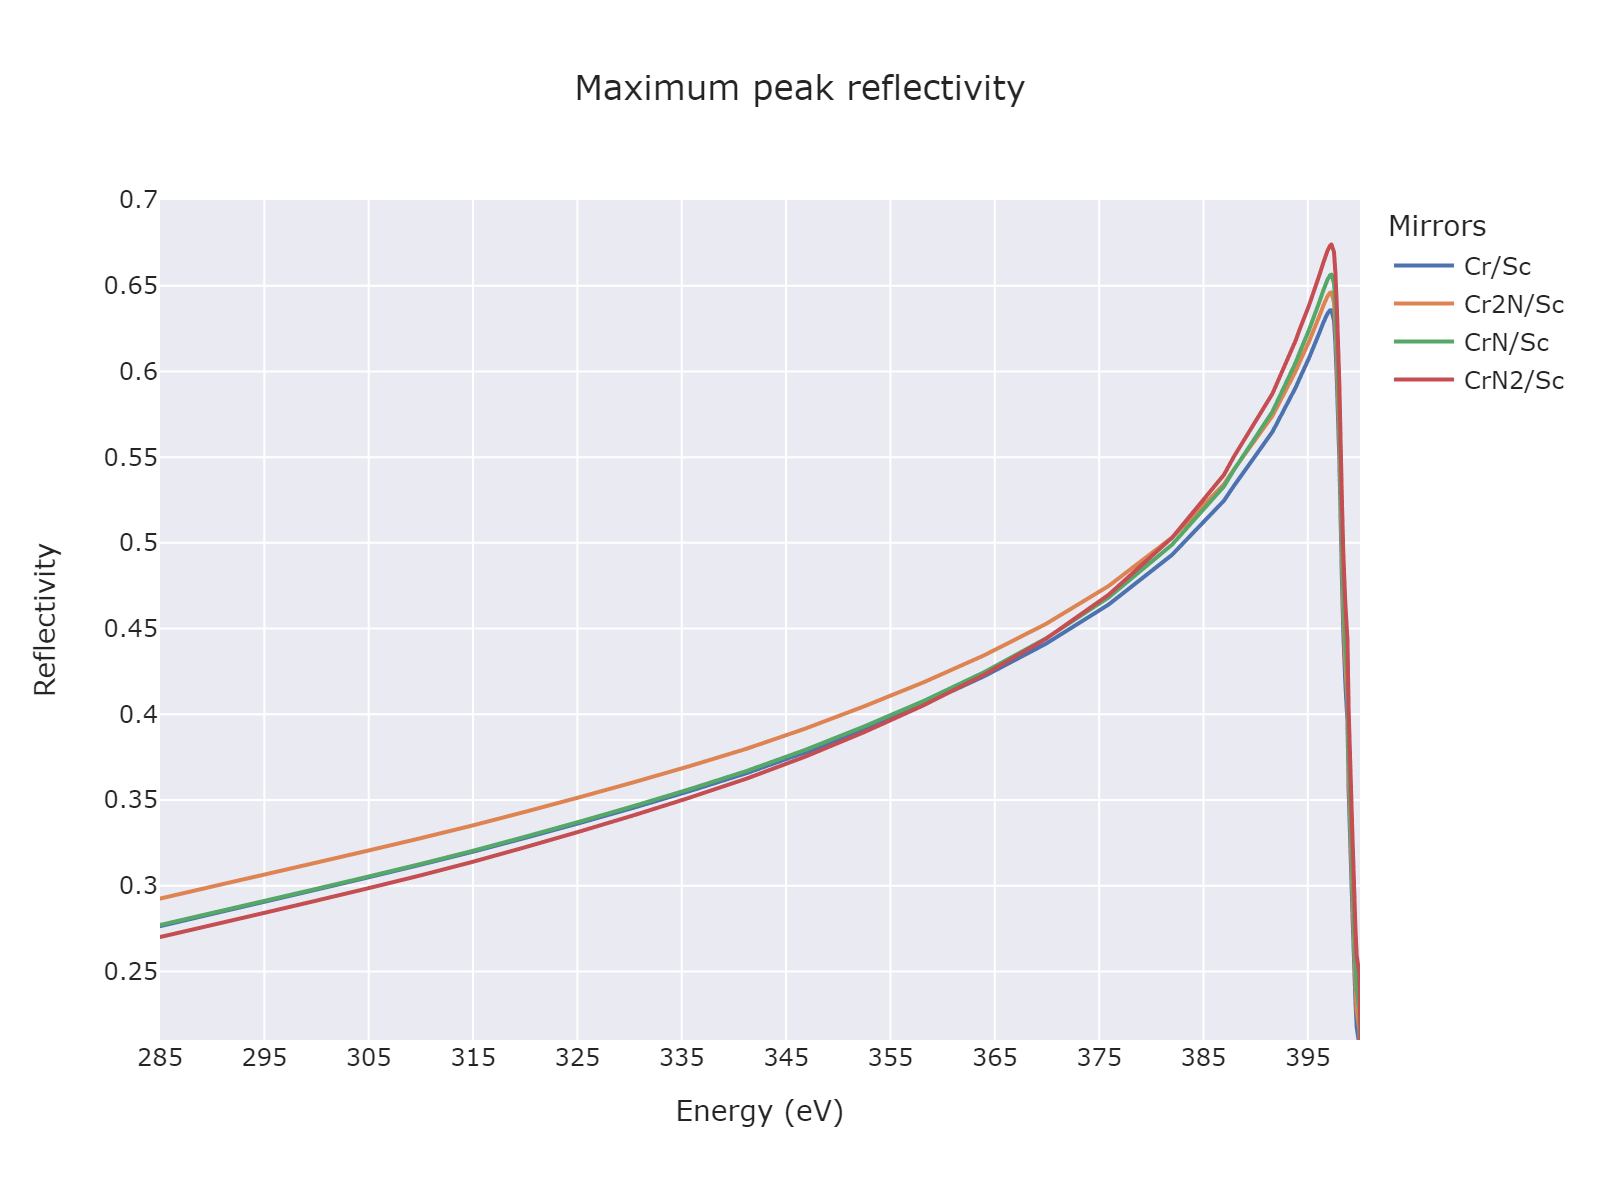

In [8]:
fig = px.line(r_max_crn, range_x=en_window, title='Maximum peak reflectivity', range_y=[0.21, 0.7], **line_params)
fig.update_layout(xaxis_title='Energy (eV)', yaxis_title='Reflectivity', legend_title_text='Mirrors',
                  xaxis = dict(tickmode = 'linear', tick0 = 285, dtick = 10))
fig.show(**show_params)

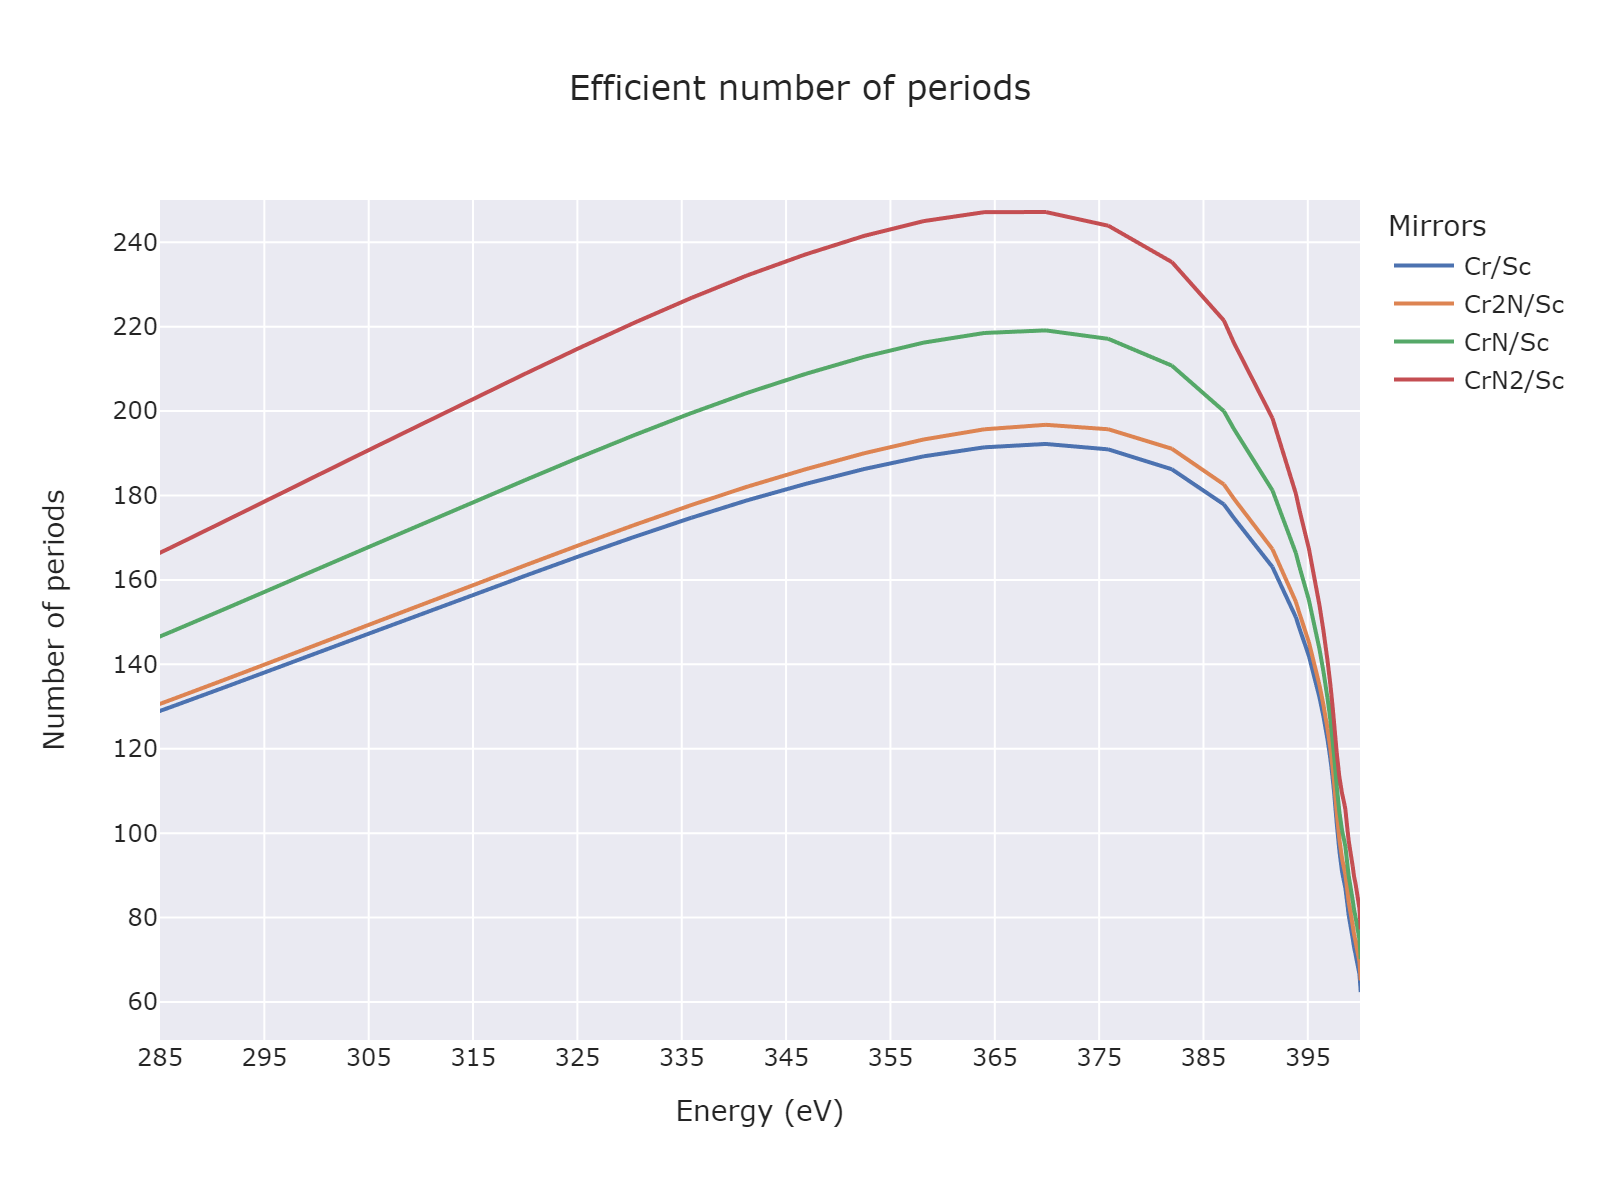

In [9]:
fig = px.line(n_eff_crn, range_x=en_window, range_y=[51, 250], title='Efficient number of periods', **line_params)
fig.update_layout(xaxis_title='Energy (eV)', yaxis_title='Number of periods', legend_title_text='Mirrors', 
                  xaxis = dict(tickmode = 'linear', tick0 = 285, dtick = 10))
fig.show(**show_params)

Из полученных результатов видно, что нитридизация хрома может привести к увеличению пикового коэффициента отражения. Причем в случае Cr2N больше всего увеличивается отражение в области далеко от края поглощения Sc, а в случае CrN2 - вблизи края поглощения Sc. Однако для того, чтобы получить наибольший пиковый коэффициент отражения в случае CrN2/Sc, придется значительно увеличить число периодов (кроме области в непосредственной близости от края поглощения).

Следует отметить, что рассчитанные абсолютные значения числа периодов для многослойных зеркал в значительной степени отличаются от оптимальных (которые составляют порядка 300), однако тенденция изменения числа слоев в разных зеркалах сохраняется.

## Нитридизация скандия

В качестве нитрида скандия будем использовать только соединение ScN, плотность для которого возьмем из Materials Project.

In [10]:
mirror_names_scn = ['Cr/Sc', 'Cr/ScN']

gammas_scn = calc_param('opt_gamma', mirror_names_crn, []).loc[397.26]
r_max_scn = calc_param('r_max', mirror_names_scn, gammas_scn)
n_eff_scn = calc_param('n_eff', mirror_names_scn, gammas_scn)

ValueError: no such compound in the database


Retrieving SummaryDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
print('Используемые значения плотностей:')
for comp in ['Sc', 'ScN']:
    print(f'{compounds[comp].chem_formula:>5}: {compounds[comp].density:.2f} g/cm^3')
    
print('\nОптимальные значения gamma:')
for i in range(len(mirror_names_scn)):
    print(f'{mirror_names_scn[i]:>8}: {gammas_scn[i]:.2f}')

Используемые значения плотностей:
   Sc: 2.99 g/cm^3
  ScN: 4.27 g/cm^3

Оптимальные значения gamma:
   Cr/Sc: 0.41
  Cr/ScN: 0.43


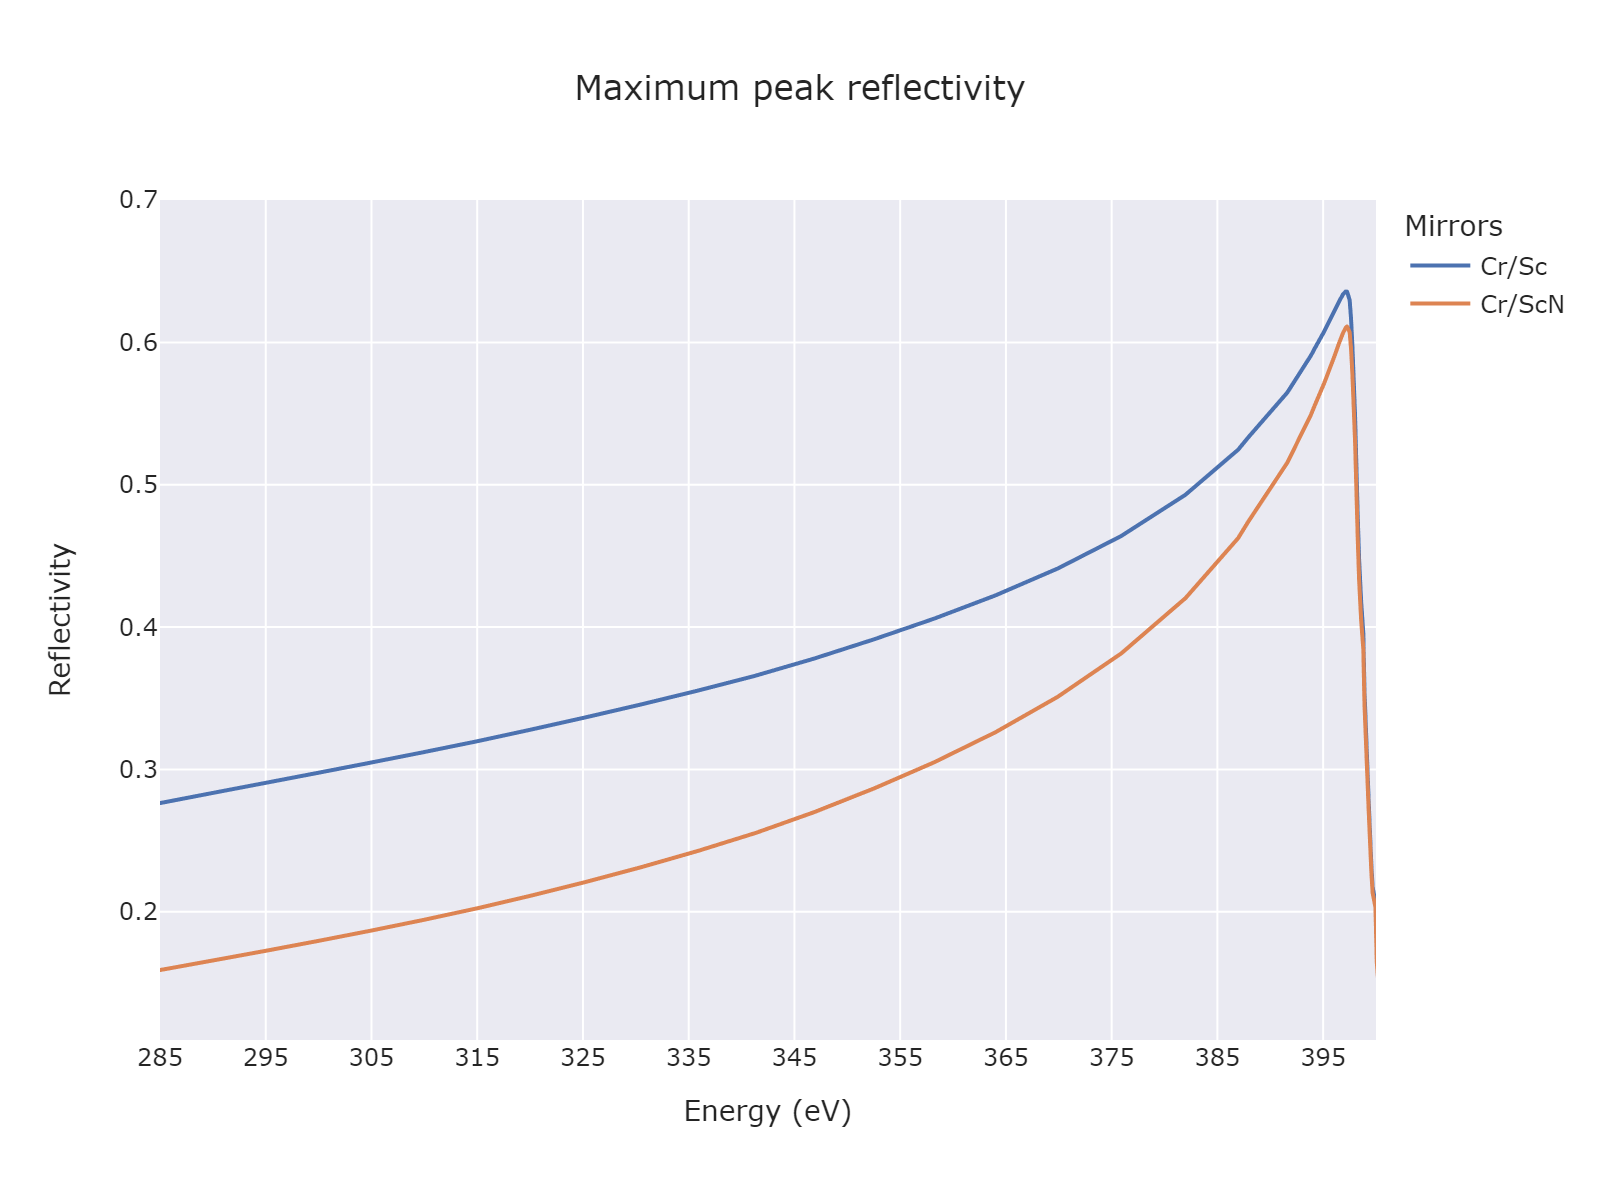

In [12]:
fig = px.line(r_max_scn, range_x=en_window, title='Maximum peak reflectivity', range_y=[0.11, 0.7], **line_params)
fig.update_layout(xaxis_title='Energy (eV)', yaxis_title='Reflectivity', legend_title_text='Mirrors', 
                  xaxis = dict(tickmode = 'linear', tick0 = 285, dtick = 10))
fig.show(**show_params)

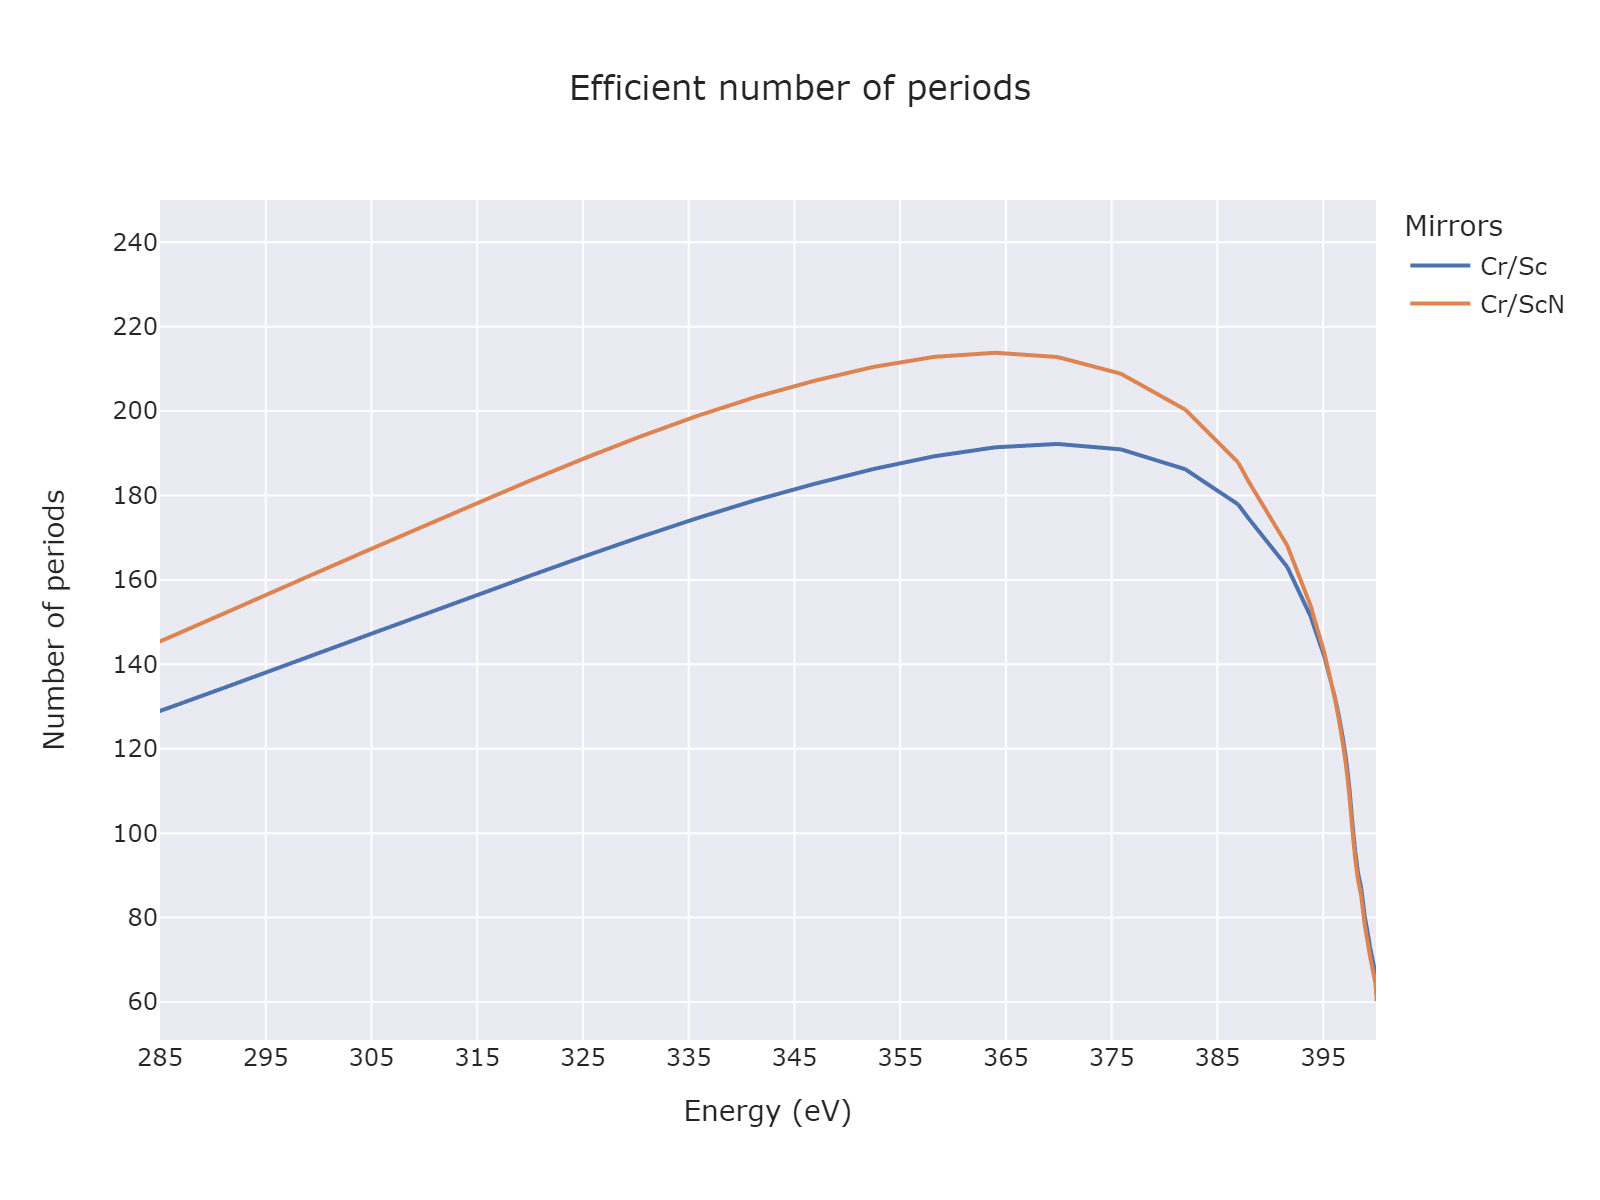

In [13]:
fig = px.line(n_eff_scn, range_x=en_window, range_y=[51, 250], title='Efficient number of periods', **line_params)
fig.update_layout(xaxis_title='Energy (eV)', yaxis_title='Number of periods', legend_title_text='Mirrors',
                  xaxis = dict(tickmode = 'linear', tick0 = 285, dtick = 10))
fig.show(**show_params)

В случае нитридизации скандия виден явный негативный эффект - во всем диапазоне рассматриваемых энергий наблюдается уменьшение отражения, при этом для достижения максимума значения пикового коэффициента отражения можно немного уменьшить число периодов, по сравнению с Cr/Sc.

## Ниртидизация хрома и скандия

Рассмотрим зеркала, в которых одновременно нитридизируется как хром, так и скандий. Значения плотностей используем те, что указаны выше.

In [14]:
# рассматриваемые пары материалов
mirror_names_crn_scn = ['Cr/Sc', 'Cr2N/ScN', 'CrN/ScN', 'CrN2/ScN']

# рассчитываем значения оптимальной гаммы для каждой пары материалов
gammas_crn_scn = calc_param('opt_gamma', mirror_names_crn_scn, []).loc[397.26]

# расчет пиковых коэффициентов отражения
r_max_crn_scn = calc_param('r_max', mirror_names_crn_scn, gammas_crn_scn)
r_max_crn_scn.index.name = 'Energy'

# расчет эффективного числа периодов
n_eff_crn_scn = calc_param('n_eff', mirror_names_crn_scn, gammas_crn_scn)
n_eff_crn_scn.index.name = 'Energy'

In [15]:
print('\nОптимальные значения gamma:')
for i in range(len(mirror_names_crn_scn)):
    print(f'{mirror_names_crn_scn[i]:>8}: {gammas_crn_scn[i]:.2f}')


Оптимальные значения gamma:
   Cr/Sc: 0.41
Cr2N/ScN: 0.44
 CrN/ScN: 0.46
CrN2/ScN: 0.49


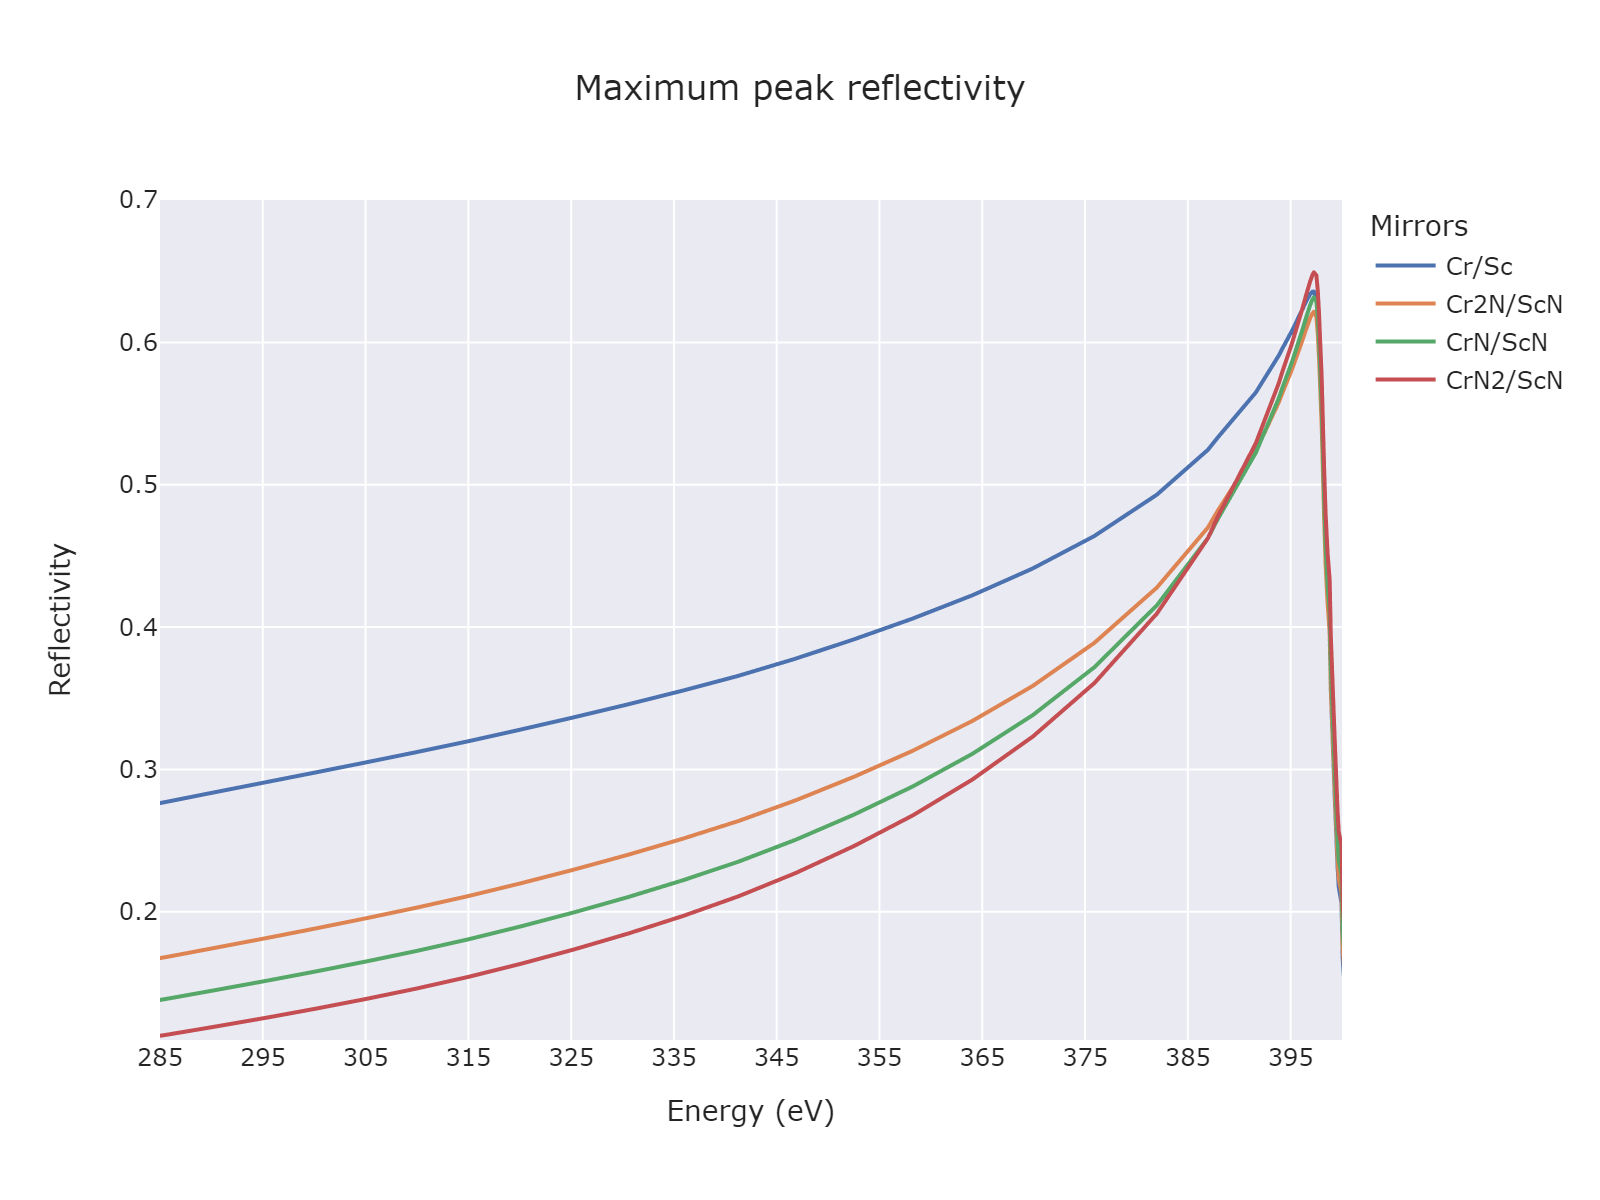

In [16]:
fig = px.line(r_max_crn_scn, range_x=en_window, title='Maximum peak reflectivity', range_y=[0.11, 0.7], **line_params)
fig.update_layout(xaxis_title='Energy (eV)', yaxis_title='Reflectivity', legend_title_text='Mirrors', 
                  xaxis = dict(tickmode = 'linear', tick0 = 285, dtick = 10))
fig.show(**show_params)

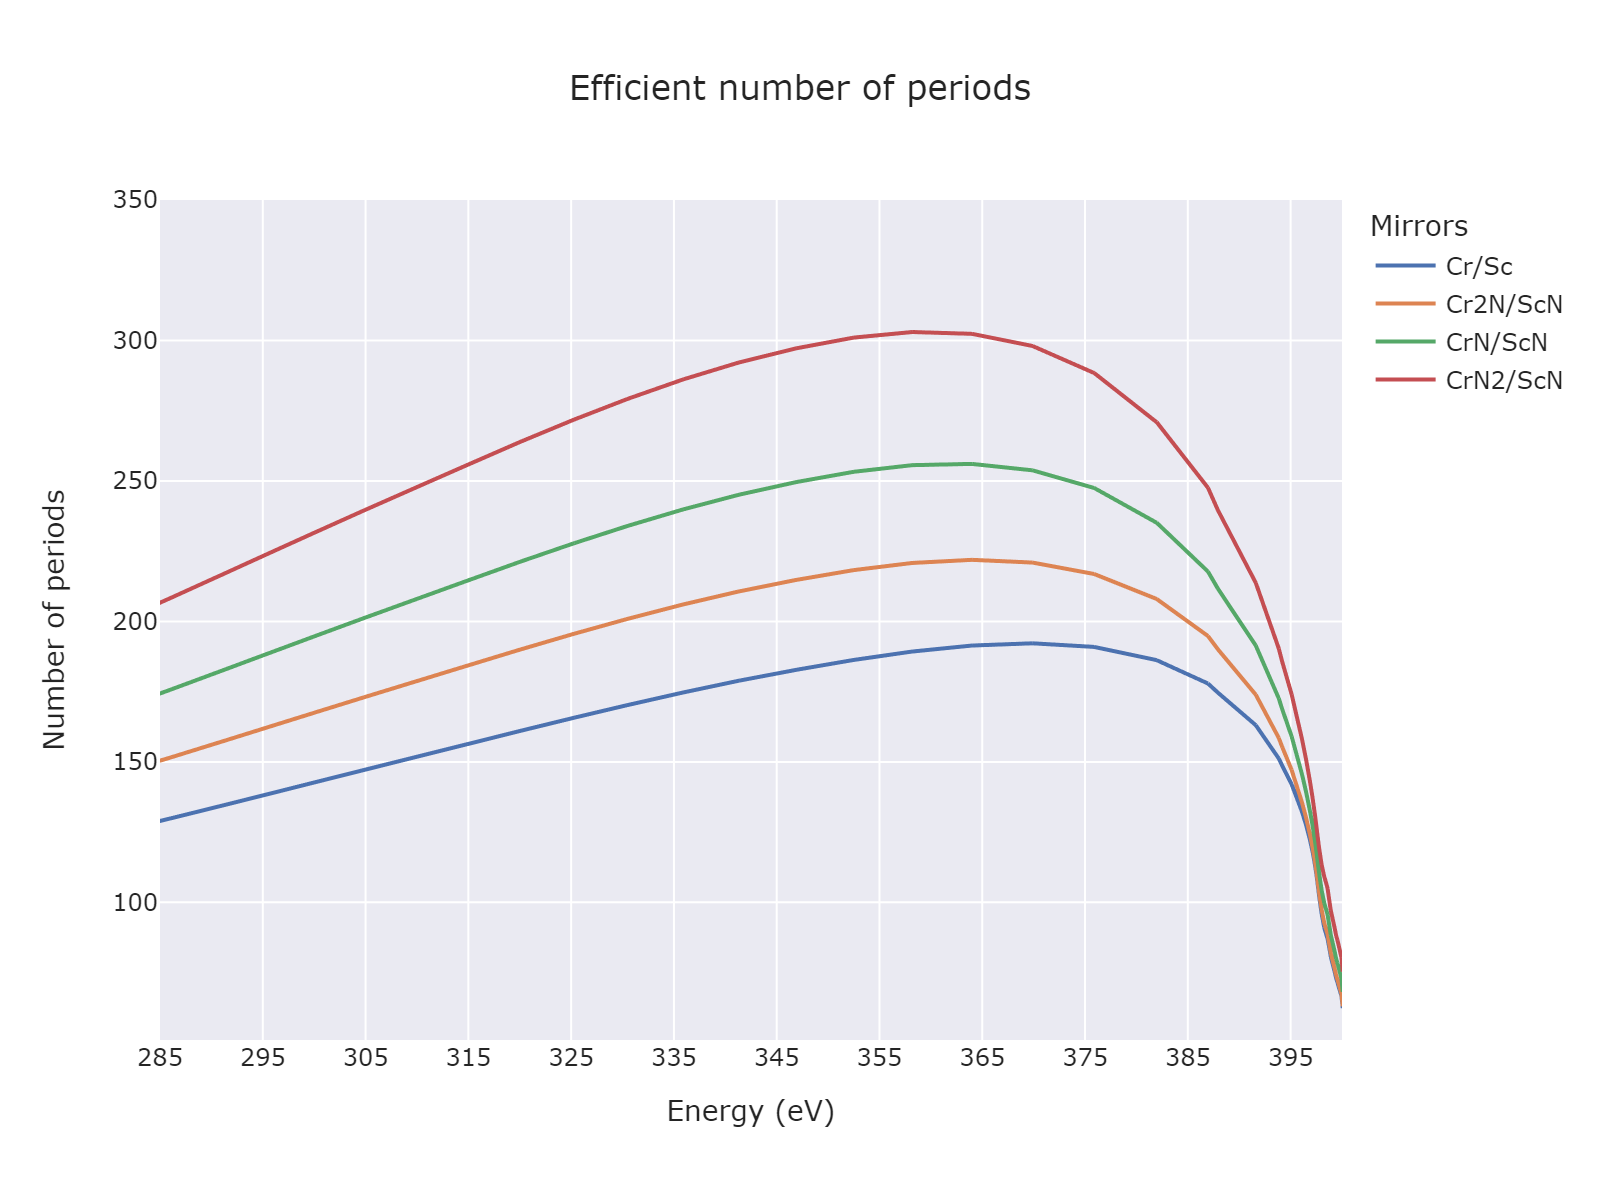

In [17]:
fig = px.line(n_eff_crn_scn, range_x=en_window, range_y=[51, 350], title='Efficient number of periods', **line_params)
fig.update_layout(xaxis_title='Energy (eV)', yaxis_title='Number of periods', legend_title_text='Mirrors',
                  xaxis = dict(tickmode = 'linear', tick0 = 285, dtick = 10))
fig.show(**show_params)

Как видно, выигрыш может дать только пара, где присутствует наибольшее количество азота в зеркале.

Рассмотренные случаи - "идеальные случаи". Никак не учитывается, что слои могут содержать несколько соединений, не учитывается влияние шероховатостей и взаимодиффузии в разных зеркалах.

## Расчет коэффициентов отражения зеркал вблизи края поглощения при нормальном падении излучения

Как мы видели ранее, для того, чтобы достичь максимального коэффициента отражения, во многих случаях требуется увеличить число пар слоев относительно исходной структуры Cr/Sc. Однако также было заметно, что вблизи края поглощения это увеличение незначительное. Проведем следующие расчеты R(E) при нормальном угле 0 градусов: зафиксируем число слоев N=300, период d=1.561 нм, будем варьировать только материалы слоев, будем использовать те значения отношений их толщин, что были рассчитаны ранее для энергии 397 эВ. Расчеты проводились в программе IMD. 

In [18]:
file_names = ['Sc_Cr', 'Sc_Cr2N', 'Sc_CrN', 'Sc_CrN2', 'ScN_Cr', 'ScN_CrN2']

reflectivities = pd.DataFrame()

for name in file_names:
    spacer, absorber = name.split('_')
    df = pd.read_csv(f'multifitting results/{name}.txt', skiprows=17, sep='\s+', names=['Energy', f'{absorber}/{spacer}'], index_col=0)
    reflectivities = pd.concat([reflectivities, df], axis=1)

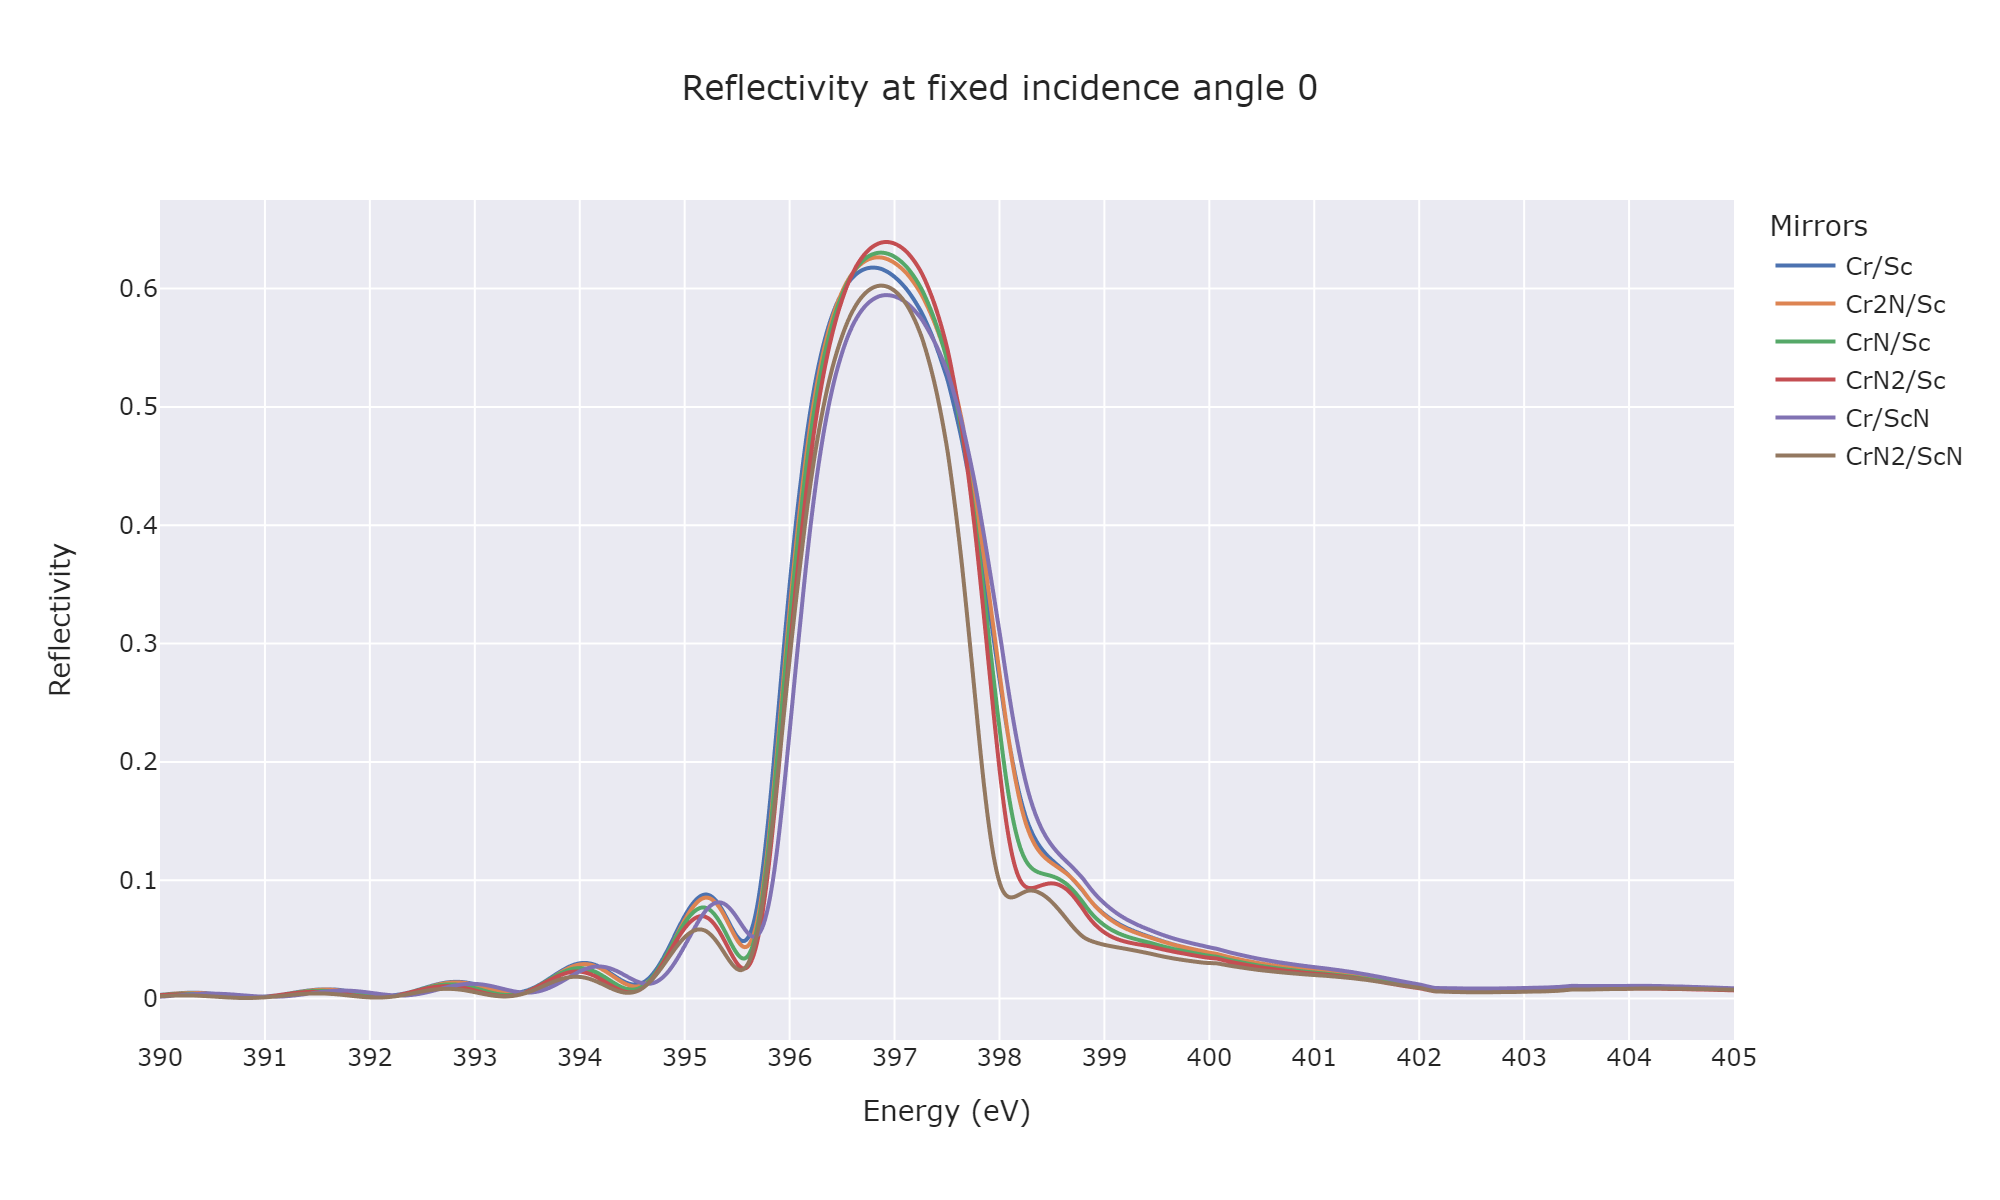

In [19]:
fig = px.line(reflectivities, width=1000, height=600, title='Reflectivity at fixed incidence angle 0', template='seaborn')
fig.update_layout(xaxis_title='Energy (eV)', yaxis_title='Reflectivity', legend_title_text='Mirrors',
                  xaxis = dict(tickmode = 'linear', tick0 = 390, dtick = 1))
fig.show(renderer='png', scale=2)

Из представленных результатов видно, что при фиксированном числе пар слоев нитридизация скандия негативно влияет на отражение, в то время как нитридизация хрома наоборот, может привести к увеличению отражения, причем чем больше азота в соединении, тем лучше.

## Анализ влияния шероховатости/диффузии

Рассмотрим влияние шероховатости/диффузии на отражение. Основной вопрос, на который мы хотим здесь ответить: "Отличается ли степень уменьшения пикового коэффициента отражения от шероховатости/диффузии для разных зеркал?". Здесь мы рассмотрим только три зеркала: Cr/Sc, CrN2/Sc и CrN2/ScN. Параметр sigma будем добавлять симметричным (sigma(Cr-on-Sc) = sigma(Sc-on-Cr)), шероховатость поверхности задаем равной 0.

In [20]:
mirror_names = ['Sc_Cr', 'Sc_Cr2N', 'Sc_CrN2', 'ScN_CrN2']
file_names = [
    *mirror_names,
    *[f'{name}_sigma={val:.1f}' for name in mirror_names for val in [0.1, 0.2, 0.3, 0.4, 0.5]],
]

reflectivities_sigma = pd.DataFrame()

for name in file_names:
    spacer, absorber = name.split('_')[:2]
    if 'sigma' in name:
        sigma = name[-3:]
    else:
        sigma = 0.0
    df = pd.read_csv(f'multifitting results/{name}.txt', skiprows=17, sep='\s+', 
                     names=['Energy', f'{absorber}/{spacer} sigma={sigma}'], index_col=0)
    reflectivities_sigma = pd.concat([reflectivities_sigma, df], axis=1)

In [21]:
df = reflectivities_sigma.reset_index()
df = df.melt(id_vars='Energy', var_name='Mirror', value_name='Reflectivity').set_index('Energy')
df = df.pivot_table(index='Mirror', values='Reflectivity', aggfunc=(('Max reflectivity', 'max'), ('Energy', 'idxmax'))).reset_index()
df['Sigma'] = df.Mirror.str.split('=').str[1].astype(float)
df['Mirror'] = df.Mirror.str.split(' ').str[0]

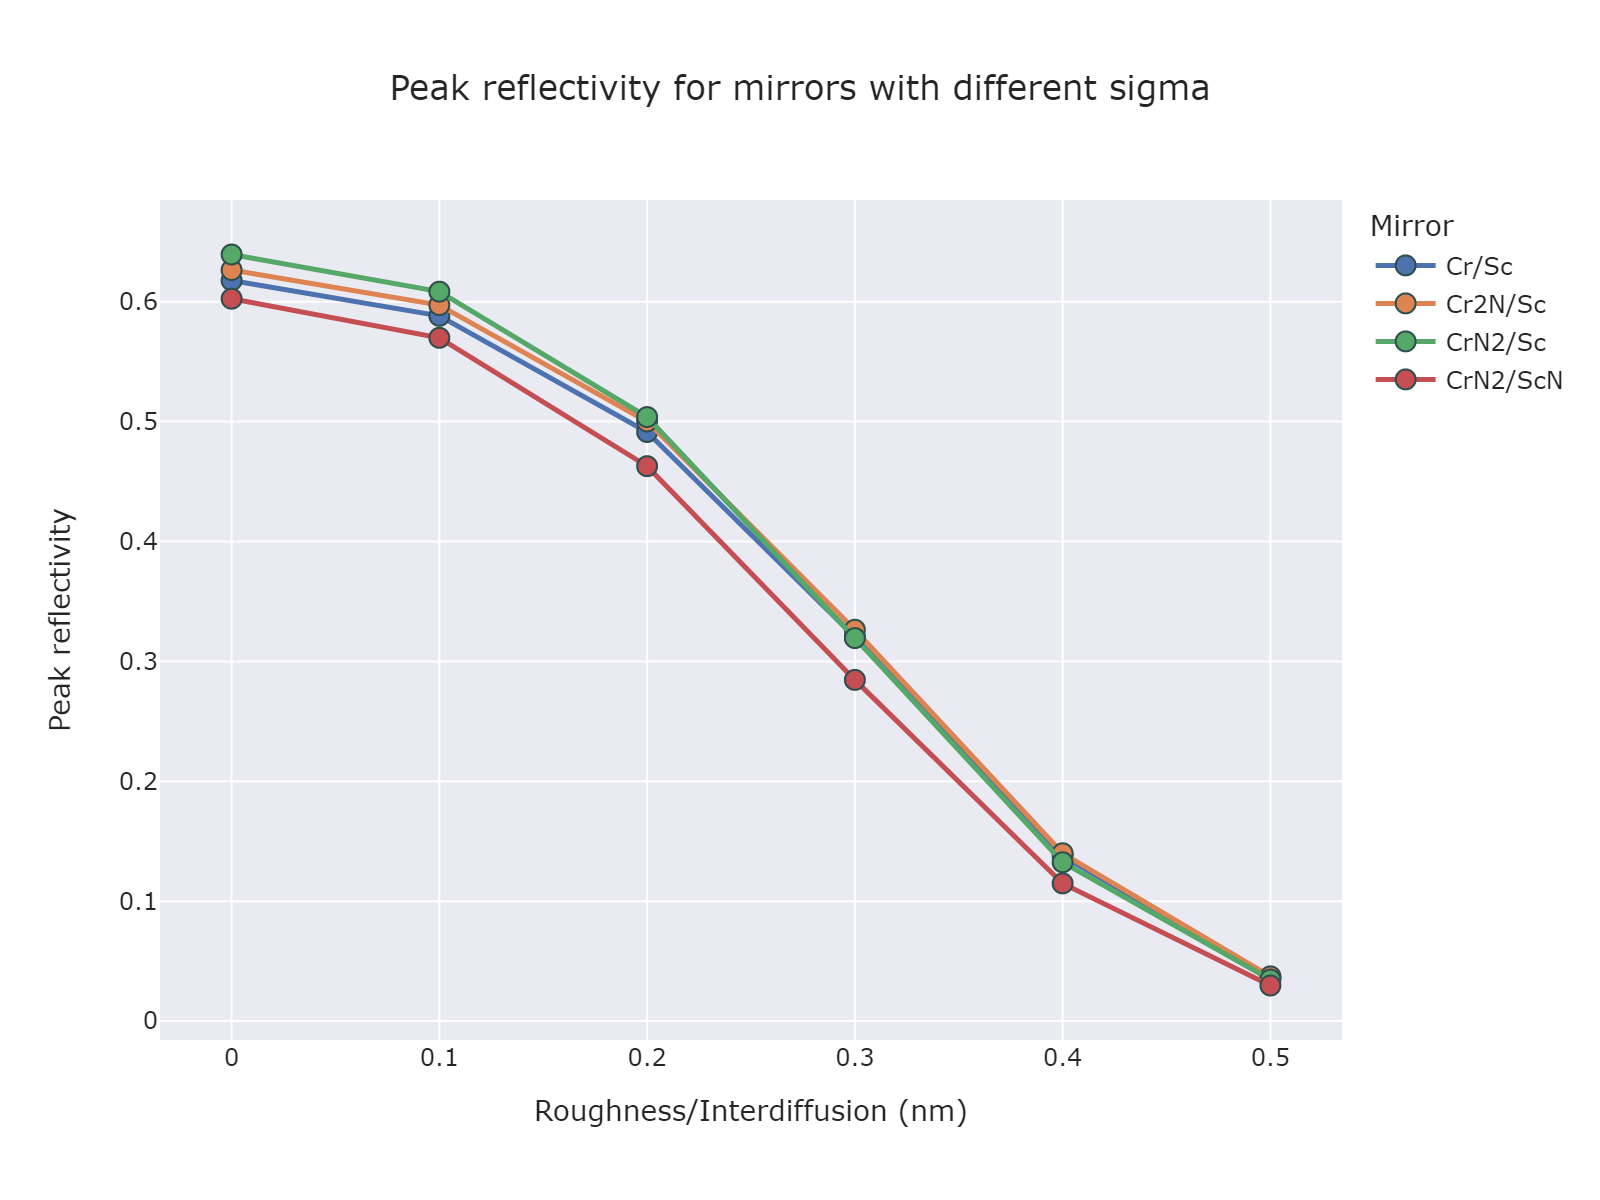

In [22]:
fig = px.line(df, x='Sigma', y='Max reflectivity', color='Mirror', markers=True,
           title='Peak reflectivity for mirrors with different sigma', **line_params)
fig.update_layout(xaxis_title='Roughness/Interdiffusion (nm)', yaxis_title='Peak reflectivity', legend_title_text='Mirror')
fig.update_traces(marker=dict(size=10, line=dict(width=1,color='DarkSlateGrey')),
                  line=dict(width=2.5))
fig.show(**show_params)

In [23]:
groups = df.groupby('Mirror')['Max reflectivity']
df['Percent diff'] = (df['Max reflectivity'] - groups.transform('first')) / groups.transform('first') * 100

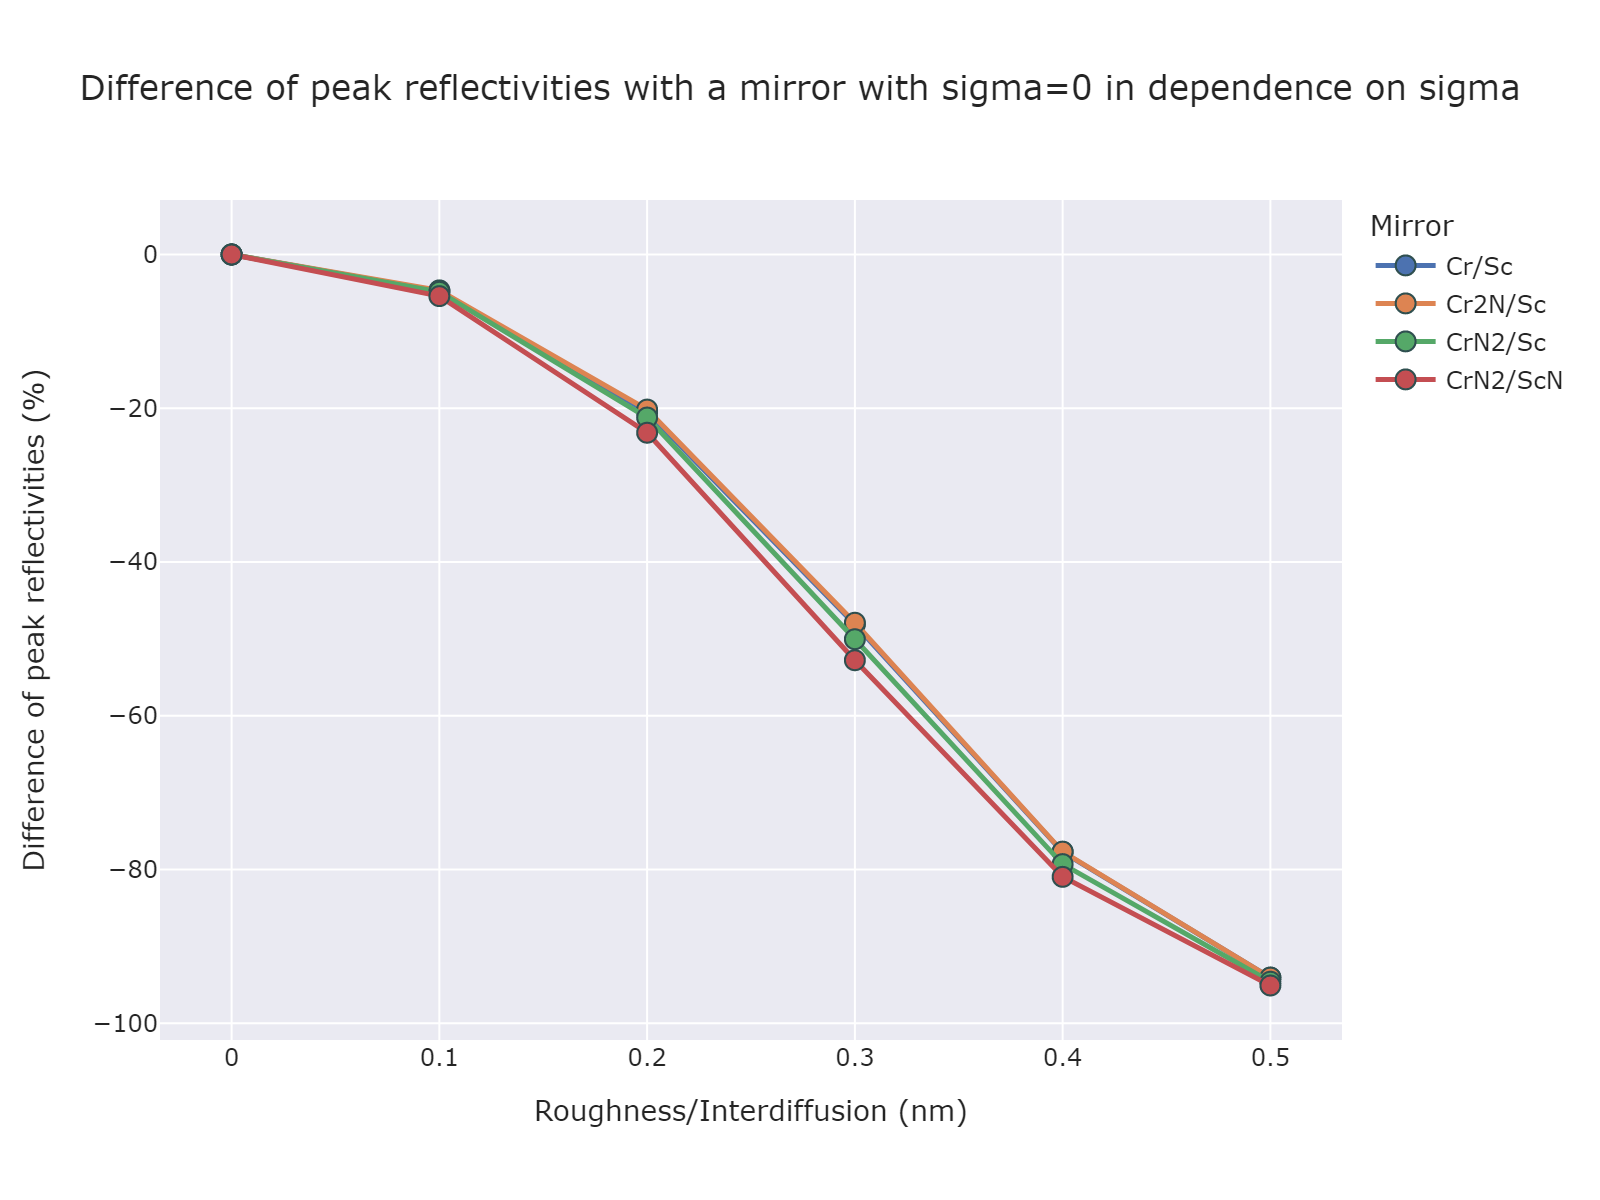

In [24]:
fig = px.line(df, x='Sigma', y='Percent diff', color='Mirror', markers=True,
           title='Difference of peak reflectivities with a mirror with sigma=0 in dependence on sigma', **line_params)
fig.update_layout(xaxis_title='Roughness/Interdiffusion (nm)', yaxis_title='Difference of peak reflectivities (%)', legend_title_text='Mirror')
fig.update_traces(marker=dict(size=10, line=dict(width=1,color='DarkSlateGrey')),
                  line=dict(width=2.5))
fig.show(**show_params)

Видно, что при увеличении шероховатости/взаимодиффузии пиковый коэффциент отражения уменьшается немного быстрее для многослойных структур, которые содержат азот. Чем больше азота, тем быстрее спад. После sigma=0.3 нм выгода от применения CrN2 сходит практически на нет, при этом использование Cr2N вмесо Cr остается лучше вплоть до sigma=0.5 нм. 

## Основные выводы

- структуры с нитридом хрома могут иметь большие коэффициенты отражения, по сравнению с "чистым" Cr/Sc;
- чтобы шероховатость/интердиффузия немного меньше снижали пиковый коэффициент отражения, необходимо использовать хром с малым содержанием азота;
- необходимо исключить формирование нитридов скандия.